In [ ]:
# install packages
!pip install contractions
!pip install bertopic
!pip install octis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 6.9 MB/s 
     |████████████████████████████████| 110 kB 67.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 3.8 MB/s 
     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 88 kB 5.3 MB/s 
     |████████████████████████████████| 5.2 MB 62.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 662 kB 72.7 MB/s 
     |████████████████████████████████| 5.8 MB 38.3 MB/s 
     |████████████████████████████████| 1.3 MB 57.6 MB/s 
     |████████████████████████████████| 182 kB 72.8 MB/s 
     |████████████████████████████████| 7.6 MB 71.9 MB/s 
     |████████████████████████████████| 1.1 M

In [135]:
# import
import pandas as pd
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from transformers.tokenization_utils_base import TokenSpan


from sklearn.cluster import KMeans
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
#from Autoencoder import *
#from preprocess import *
# from datetime import datetime
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

In [ ]:
# Run this line if fail to import bertopic
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 306 kB 7.4 MB/s 
  Attempting uninstall: joblib
    Found existing installation: joblib 1.2.0
    Uninstalling joblib-1.2.0:
      Successfully uninstalled joblib-1.2.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Capstone Project/"

In [ ]:
data= pd.read_csv(data_path+'Data/new_data_cleaned_sample.csv')

In [ ]:
data

,Unnamed: 0,email_id,subject,email,bow,embeddings
0,0,taylor-m\all_documents\3696#1,ETS Risk Assessment Reporting Memorandum,taylor-m\all_documents\3696,dear discussed attached please find memorandum...,"dear al: discussed, attached please find memor..."
1,1,sanchez-m\deleted_items\7#1,prebon/ene dinner,sanchez-m\deleted_items\7,guy know past week asking guy could come prebo...,guys...i know past week asking guy could come ...
2,2,white-s\deleted_items\616#1,ERV Notification: (West Power Desk Daily Pric...,white-s\deleted_items\616,report named west power desk daily price repor...,report named: west power desk daily price repo...
3,3,hyatt-k\enron_kids\6#1,Conference Room Reservations,hyatt-k\enron_kids\6,need schedule mega conference room enron kid m...,need schedule mega conference room enron kid m...
4,4,germany-c\all_documents\1696#1,Iroq parking deal,germany-c\all_documents\1696,gang fairly certain entered parking deal wrong...,gang. i'm fairly certain entered parking deal ...
...,...,...,...,...,...,...
17569,17569,shackleton-s\inbox\1147#1,APEA,shackleton-s\inbox\1147,dale working jeff dellapina chase potential re...,dale working jeff dellapina chase potential re...
17570,17570,shackleton-s\inbox\1147#2,RE: APEA,shackleton-s\inbox\1147,worked sara shackleton swap deal someone else ...,worked sara shackleton swap deal. someone else...
17571,17571,mann-k\all_documents\530#1,Status of MEH activities,mann-k\all_documents\530,gentleman thought would pull together brief em...,"gentlemen, thought would pull together brief e..."
17572,17572,farmer-d\all_documents\304#1,Industrials,farmer-d\all_documents\304,november industrial spreadsheet two outstandin...,november industrial spreadsheet. two outstandi...


In [ ]:
text = list(data['bow'])
sentences = list(data['embeddings'])

# LDA

In [ ]:
def LDA(text, k=7):
  """
  train LDA model
  
  :param text: list of text data for training
  :param k: number of topics
  :return: lda model and representative vectors
  """

  # train lda model
  token_lists = [s.split() for s in data['bow']]
  dictionary = corpora.Dictionary(token_lists)
  corpus = [dictionary.doc2bow(text) for text in token_lists]
  lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=7, id2word=dictionary, passes=20)

  # Calculate probabilities of topic assginment as representative vectors
  lda_vec = np.zeros((len(corpus), k))
  for i in range(len(corpus)):
      for topic, prob in lda_model.get_document_topics(corpus[i]):
          lda_vec[i][topic] = prob

  return lda_model, lda_vec


In [ ]:
lda_model, lda_vec = LDA(text, 7)

# Embedding

In [ ]:
# Get BERT embedding of text
st = SentenceTransformer('all-MiniLM-L6-v2')
bertopic_vec = np.array(st.encode(sentences, show_progress_bar=True)) # BERT embedding

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

In [101]:
# combine lda vectors and BERT embedding vectors

lda_ss = StandardScaler()
lda_vec_ss = lda_ss.fit_transform(lda_vec)
bertopic_ss = StandardScaler()
bertopic_vec_ss = bertopic_ss.fit_transform(bertopic_vec)
combined_vec = np.c_[lda_vec_ss, bertopic_vec_ss] # combination of LDA and BERT embedding vectors

# BERTopic

In [ ]:
def create_model(topwords,n_gram,nr_topics, cluster_method):
  stop_w = ['imagemasker','urlmasker', 'namemasker', 'please', 'fyi']
  vectorizer_model = CountVectorizer(ngram_range=n_gram, stop_words=stop_w)
  umap_model = UMAP(metric='euclidean')
  if cluster_method == "kmeans":
    cluster_model = KMeans(n_clusters=nr_topics)
    model = BERTopic(top_n_words=topwords,
                    vectorizer_model=vectorizer_model,
                    umap_model=umap_model, 
                    nr_topics=nr_topics,
                    hdbscan_model=cluster_model)
  else:
    model = BERTopic(top_n_words=topwords,
                    vectorizer_model=vectorizer_model,
                    umap_model=umap_model, 
                    nr_topics='auto', diversity = 0.8)
  return model

In [ ]:
'''
number of top words: 10
range of n-grams: (1,2)
clustering method: HDBScan
number of topics: auto
'''
model_bertopic = create_model(10, (1,2),'auto', 'hdbscan')

In [ ]:
topics, probs = model_bertopic.fit_transform(text, bertopic_vec)

In [ ]:
model_bertopic.save(data_path+"Bertopic_model")

/usr/local/lib/python3.8/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



### BERTopic reuslt

In [ ]:
model_bertopic = 	BERTopic.load(data_path+"Bertopic_model")

In [ ]:
model_bertopic.visualize_topics()

In [ ]:
model_bertopic.visualize_barchart(topics=range(10), n_words = 10, height = 300)

In [ ]:
hierarchical_topics = model_bertopic.hierarchical_topics(text)
model_bertopic.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 249/249 [00:03<00:00, 68.90it/s]


# LDA + BERTopic

In [ ]:
'''
number of top words: 10
range of n-grams: (1,1)
clustering method: K-means
number of topics: 7
'''
model_combined = create_model(10,(1,1),7, 'kmeans')

In [ ]:
topics, probs = model_combined.fit_transform(text, combined_vec)

In [ ]:
model_combined.save(data_path+"Combined_model")

### LDA + BERTopic result

In [85]:
model_combined = 	BERTopic.load(data_path+"Combined_model")

In [ ]:
model_combined.visualize_topics()

In [88]:
model_combined.visualize_barchart(topics=range(7), n_words = 10, height = 300)

In [ ]:
hierarchical_topics = model_combined.hierarchical_topics(text)
model_combined.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 6/6 [00:00<00:00, 144.78it/s]


### Topic assignment of 30 samples

In [86]:
sample = pd.read_csv(data_path+'Data/30_selected_samples.csv')

In [112]:
data['combined_vec'] = list(combined_vec)
sample = sample.merge(data[["email_id","combined_vec"]], on= "email_id", how = "left")
sample_text = list(sample["bow"])
sample_embeddings = np.array(list(sample["combined_vec"]))

In [117]:
topics, _ = model_combined.transform(sample_text, sample_embeddings)

In [152]:
sample["topic"] = topics
sample

,Unnamed: 0,email_id,subject,email,bow,embeddings,combined_vec,topic
0,0,mann-k\all_documents\3749#4,Re: Form of Letter Agreement for Purchase of ...,mann-k\all_documents\3749,draft northwestern corp well let try left refe...,"&=draft northwestern corp. =well, let's try th...","[-0.36245390287383494, -0.5241633821942518, -0...",3
1,1,dasovich-j\sent_items\1136#2,RE: The Gas Settlement that Wouldn't Die,dasovich-j\sent_items\1136,jeff give call heard response party plan comme...,"jeff, give call heard response, party plan com...","[-0.23825633987390774, -0.42639116434880914, -...",4
2,2,heard-m\inbox\master_netting\138#1,Process Memo: Please Read,heard-m\inbox\master_netting\138,importance high cordially mary cook,"importance: high cordially, mary cook","[2.7406919439416315, -0.3610103828878561, -0.7...",4
3,3,nemec-g\all_documents\4906#2,Interconnect Agreement between RNP and HPL,nemec-g\all_documents\4906,hopefully final comment rio nogales attached i...,hopefully final comment rio nogales attached b...,"[0.3939590939643289, -0.5241633821942518, 0.52...",4
4,4,kaminski-v\sent_items\2348#3,FW: 7/30 Prediction meeting,kaminski-v\sent_items\2348,norman thanks message treat monday meeting opp...,"norman, thanks message. treat monday meeting o...","[-0.36245390287383494, -0.29049234557744347, 0...",4
5,5,geaccone-t\deleted_items\53#1,Tw CE and 2002 Plan,geaccone-t\deleted_items\53,tracy could please send info commercial 3rd al...,"tracy, could please send info commercial 3rd a...","[-0.36245390287383494, -0.5241633821942518, -0...",4
6,6,love-p\sent_items\459#2,RE: vacation,love-p\sent_items\459,take friday want get back know going far know ...,"take friday want, get back know going far know...","[-0.26695462689806837, -0.4488621900510867, -0...",2
7,7,farmer-d\all_documents\3586#2,Re: Meter 986315 for 10/00,farmer-d\all_documents\3586,person cleco foursquare kara phone number,person cleco foursquare kara phone number,"[-0.18177882531376882, -0.38168463651136986, -...",3
8,8,mann-k\all_documents\3612#1,City of Austin Agreement,mann-k\all_documents\3612,attached please find clean copy recent version...,attached please find clean copy recent version...,"[-0.36245390287383494, -0.5241633821942518, -0...",0
9,9,farmer-d\all_documents\1428#1,Hydrocarbon Lease Mgmt.,farmer-d\all_documents\1428,neal new deal ticket rolled july please advise...,"o'neal, new deal ticket rolled july? please ad...","[-0.2381057489439901, -0.4255507479493096, -0....",4


In [148]:
sample.to_csv(data_path+"Data/30_selected_samples_combined.csv")

# Evaluation

In [ ]:
def evaluation(method, model, text, ngram_range):
  '''
  Calculate the coherence and diversity of models

  :param model: trained model
  :param text: training data
  :param ngram_range: ngram_range of trained model
  :return: coherence and diversity of model
  '''
  # get tokens of text
  vectorizer = CountVectorizer(ngram_range=ngram_range)
  tokenized = vectorizer.fit_transform(text)
  tokens = vectorizer.inverse_transform(tokenized)
  tokens = [list(a) for a in tokens if list(a)]
  if ngram_range != (1,1):
    token_lists = [['_'.join(word.split()) for word in words] for words in tokens if words]
  else:
    token_lists = tokens
  dictionary = corpora.Dictionary(token_lists)
  corpus = [dictionary.doc2bow(text) for text in token_lists]

  if method == "LDA":
    # calculate coherence
    cm = CoherenceModel(model=model, texts=token_lists, corpus=corpus, dictionary=dictionary, coherence="c_v")
    coherence = cm.get_coherence()
    # calculate diveristy
    topics = model.show_topics(formatted=False)
    lda_topics = [[word[0] for word in words[1]] for words in topics]
    lda_output = {"topics":lda_topics}
    td = TopicDiversity(topk=10)
    diversity = td.score(lda_output)

  else: # method = "BERTopic"
    # get top words in topics
    all_words = set([word for words in token_lists for word in words])
    nr_topics = len([i for i in model.get_topics().keys() if i != -1])
    bertopic_topics = [['_'.join(vals[0].split()) for vals in model.get_topic(i)[:10]] for i in range(nr_topics)]
    bertopic_topics = [[word for word in words if word in all_words] for words in bertopic_topics]
    bertopic_topics = [words for words in bertopic_topics if words]
    div_topics = [[vals[0] for vals in model.get_topic(i)[:10]] for i in range(nr_topics)]
    # calculate coherence
    cm = CoherenceModel(topics=bertopic_topics, texts=token_lists, corpus = corpus, dictionary = dictionary, coherence='c_v')
    coherence = cm.get_coherence()
    # calculate diveristy
    bertopic_output = {"topics":div_topics}
    td = TopicDiversity(topk=10)
    diversity = td.score(bertopic_output)

  return coherence, diversity

In [ ]:
comparison = pd.DataFrame(columns=['LDA', 'BERTopic', 'LDA+BERTopic'], index = ['coherence', 'diversity'])

In [ ]:
comparison['LDA'] = evaluation("LDA", lda_model, text,(1,1))
comparison['BERTopic'] = evaluation("BERTopic", model_bertopic, text,(1,2))
comparison['LDA+BERTopic'] = evaluation("BERTopic", model_combined, text,(1,1))

In [ ]:
comparison

,LDA,BERTopic,LDA+BERTopic
coherence,0.683760,0.511502,0.619205
diversity,0.771429,0.854400,0.842857


# Fine-tuning

In [ ]:
vec = {}
vec["LDA"] = lda_vec
vec["BERTopic"] = bertopic_vec
vec["LDA_BERTopic"] = combined_vec

In [ ]:
def train_model(method, ngram_range, nr_topics, cluster_model):
  embeddings = vec[method]
  model=create_model(10,ngram_range,nr_topics, cluster_model)
  topics, probs = model.fit_transform(text, embeddings)
  coherence, diversity = evaluation(method, model, text, ngram_range)
  return coherence, diversity

In [153]:
train_model("LDA_BERTopic", (1,1), 7, "kmeans")

(0.701150766468067, 0.6857142857142857)

In [ ]:
coherences = {'LDA_BERTopic':{}, 'BERTopic':{}}
diversities = {'LDA_BERTopic':{}, 'BERTopic':{}}

In [154]:
nr_topics_list = [int(x) for x in np.linspace(10,100,10)]

for nr_topics in nr_topics_list:
  coh,div = train_model('LDA_BERTopic', (1,2), nr_topics, 'kmeans')
  coherences['LDA_BERTopic'][nr_topics]=coh
  diversities['LDA_BERTopic'][nr_topics]=div
  coh,div = train_model('BERTopic', (1,2), nr_topics, 'kmeans')
  coherences['BERTopic'][nr_topics]=coh
  diversities['BERTopic'][nr_topics]=div

Text(0, 0.5, 'Coherence')

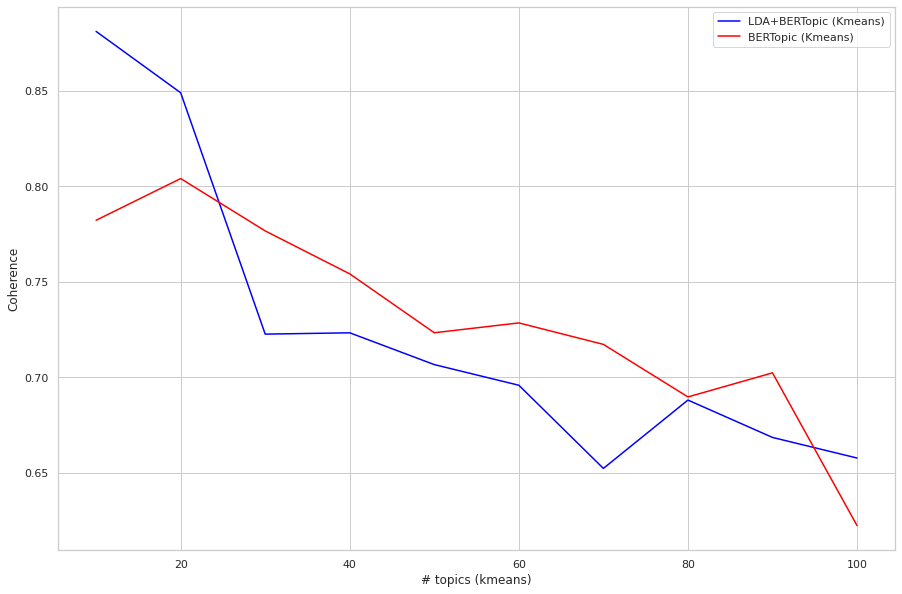

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(x=coherences['LDA_BERTopic'].keys(), y=coherences['LDA_BERTopic'].values(), color="blue", label="LDA+BERTopic (Kmeans)", linestyle="-")
sns.lineplot(x=coherences['BERTopic'].keys(), y=coherences['BERTopic'].values(), color="red", label="BERTopic (Kmeans)", linestyle="-")
plt.legend()
plt.xlabel('# topics (kmeans)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Diversity')

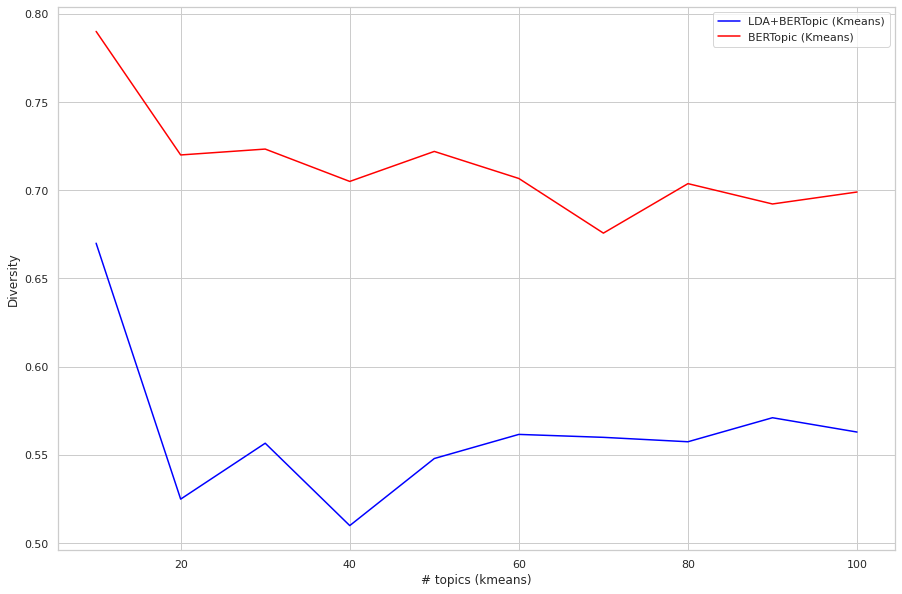

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.lineplot(x=diversities['LDA_BERTopic'].keys(), y=diversities['LDA_BERTopic'].values(), color="blue", label="LDA+BERTopic (Kmeans)", linestyle="-")
sns.lineplot(x=diversities['BERTopic'].keys(), y=diversities['BERTopic'].values(), color="red", label="BERTopic (Kmeans)", linestyle="-")
plt.legend()
plt.xlabel('# topics (kmeans)')
plt.ylabel('Diversity')

In [157]:
train_model("LDA_BERTopic", (1,1), "auto", "hdbscan")

(0.37009601930317837, 0.7678391959798995)

In [158]:
train_model("BERTopic", (1,2), "auto", "hdbscan")

(0.59845017979523, 0.9473684210526315)